# Inventory of Kaggle TensorFlow Speech Recognition Files

Files from [Kaggle Site](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

Verify properties of all files are as expected.

Find duplicate files in the train and test sets.

Earl F Glynn

* 2017-12-04.  Initial version

* 2017-07-07.  Updated to include wave amplitude quantiles, mean, sd, range; test inventory file.


## Setup

In [72]:
options(width=130)

suppressWarnings( library(dplyr) )
library(tibble)     # rownames_to_column
library(stringr)    # word
library(tools)      # md5sum
library(tuneR)      # readWave
suppressMessages( library(doParallel) )  # foreach 

dataDir <- "../../input/"   

# Train Files

## Get names of all train files

Ignore _background\_noise_ directory here.  Only ask for .wav files

In [73]:
trainFilenames <- list.files(path=paste0(dataDir, "train"), 
                             pattern="^.*\\.wav$",
                             recursive=TRUE, full.names=TRUE)

length(trainFilenames)
head(trainFilenames )

[1] 64721

[1] "../../input/train/audio/bed/00176480_nohash_0.wav" "../../input/train/audio/bed/004ae714_nohash_0.wav"
[3] "../../input/train/audio/bed/004ae714_nohash_1.wav" "../../input/train/audio/bed/00f0204f_nohash_0.wav"
[5] "../../input/train/audio/bed/00f0204f_nohash_1.wav" "../../input/train/audio/bed/012c8314_nohash_0.wav"

## Create md5sum and collect sound properties for each file

Use parallel processing to speed up md5sum computations. Let's use all but 2 cores for md5sums.

trainSoundInfo will be written to a file for easy selection of wav files later based on various properties.

In [74]:
cluster <- makePSOCKcluster(detectCores() - 2)
registerDoParallel(cluster)   

trainSoundInfo <- foreach(i = 1:length(trainFilenames), .combine=rbind) %dopar%
{    
    soundWave <- tuneR::readWave(trainFilenames[i])
    
    q <- quantile(soundWave@left, c(0.0, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0))
    
    data.frame(
           filename          = trainFilenames[i],          
           samples           = length(soundWave@left),
           durationSeconds   = length(soundWave@left) / soundWave@samp.rate,
           samplingRateHertz = soundWave@samp.rate,
           channels          = ifelse(soundWave@stereo, "Stero", "Mono"),
           pcmIntFormat      = soundWave@pcm,
           bitsPerSample     = soundWave@bit,
        
           # Waveform stats
           min               = q[1],   # Quantiles
           Q10               = q[2],
           Q25               = q[3],
           median            = q[4],
           Q75               = q[5],
           Q90               = q[6],        
           max               = q[7],
        
           range             = q[7] - q[1],
        
           mean              = mean(soundWave@left),
           sd                = sd(soundWave@left),
        
           md5sum            = tools::md5sum(trainFilenames[i]),
        
           row.names         = NULL,
           stringsAsFactors  = FALSE)
}

stopCluster(cluster)

In [75]:
dim(trainSoundInfo)

[1] 64721    18

In [76]:
head(trainSoundInfo)

filename,samples,durationSeconds,samplingRateHertz,channels,pcmIntFormat,bitsPerSample,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
../../input/train/audio/bed/00176480_nohash_0.wav,16000,1.0000000,16000,Mono,TRUE,16,-16039,-1767.4,-18,0,11,337.0,24735,40774,-1.0628750,3043.4817,3336677cade31ae52d0f9e6288ad679d
../../input/train/audio/bed/004ae714_nohash_0.wav,16000,1.0000000,16000,Mono,TRUE,16,-11421,-558.0,-149,-100,-50,285.1,12740,24161,-95.1914375,1220.9112,6ea166114fb6b1466c06e6cf0d88aa8d
../../input/train/audio/bed/004ae714_nohash_1.wav,14861,0.9288125,16000,Mono,TRUE,16,-5797,-368.0,-143,-99,-53,136.0,7021,12818,-95.1184981,601.7973,1f68560e13cc793a24b7534c13c1f7e9
../../input/train/audio/bed/00f0204f_nohash_0.wav,16000,1.0000000,16000,Mono,TRUE,16,-2474,-322.1,-43,-1,34,218.1,2327,4801,0.0856875,373.0592,fac98e7ea4e2f6f71814410d05d717cd
../../input/train/audio/bed/00f0204f_nohash_1.wav,16000,1.0000000,16000,Mono,TRUE,16,-2527,-243.0,-38,0,33,166.1,2537,5064,0.0897500,396.6656,9460317598ff20131007088e4d2d1a8f
../../input/train/audio/bed/012c8314_nohash_0.wav,16000,1.0000000,16000,Mono,TRUE,16,-3268,45.0,170,249,336,439.0,2887,6155,242.9836250,375.1439,8e9b5701dafd8d2d79f6b8062b7a11d0


## Verify sound properties common for all train files

In [77]:
table(trainSoundInfo$samplingRateHertz)


16000 
64721 

In [78]:
table(trainSoundInfo$channels)


 Mono 
64721 

In [79]:
table(trainSoundInfo$pcmIntFormat)


 TRUE 
64721 

In [80]:
table(trainSoundInfo$bitsPerSample)


   16 
64721 

Since the above sound properties were verified to be constants, let's not bother with them.


In [81]:
trainSoundInfo <- trainSoundInfo %>% select(filename, samples, 
                                            min, Q10, Q25, median, Q75, Q90, max, range,
                                            mean, sd,
                                            md5sum)
head(trainSoundInfo)

filename,samples,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
../../input/train/audio/bed/00176480_nohash_0.wav,16000,-16039,-1767.4,-18,0,11,337.0,24735,40774,-1.0628750,3043.4817,3336677cade31ae52d0f9e6288ad679d
../../input/train/audio/bed/004ae714_nohash_0.wav,16000,-11421,-558.0,-149,-100,-50,285.1,12740,24161,-95.1914375,1220.9112,6ea166114fb6b1466c06e6cf0d88aa8d
../../input/train/audio/bed/004ae714_nohash_1.wav,14861,-5797,-368.0,-143,-99,-53,136.0,7021,12818,-95.1184981,601.7973,1f68560e13cc793a24b7534c13c1f7e9
../../input/train/audio/bed/00f0204f_nohash_0.wav,16000,-2474,-322.1,-43,-1,34,218.1,2327,4801,0.0856875,373.0592,fac98e7ea4e2f6f71814410d05d717cd
../../input/train/audio/bed/00f0204f_nohash_1.wav,16000,-2527,-243.0,-38,0,33,166.1,2537,5064,0.0897500,396.6656,9460317598ff20131007088e4d2d1a8f
../../input/train/audio/bed/012c8314_nohash_0.wav,16000,-3268,45.0,170,249,336,439.0,2887,6155,242.9836250,375.1439,8e9b5701dafd8d2d79f6b8062b7a11d0


## Look at sample size differences

In [82]:
fivenum(trainSoundInfo$samples)

[1]  5945 16000 16000 16000 16000

Number of files with exactly 16000 samples (1 second duration):

In [83]:
sum(trainSoundInfo$samples == 16000)

[1] 58252

Fraction that are exactly 16000 samples (1 second):

In [84]:
sum(trainSoundInfo$samples == 16000) / nrow(trainSoundInfo)

[1] 0.9000479

Look at variation in files with fewer than 16000 samples:

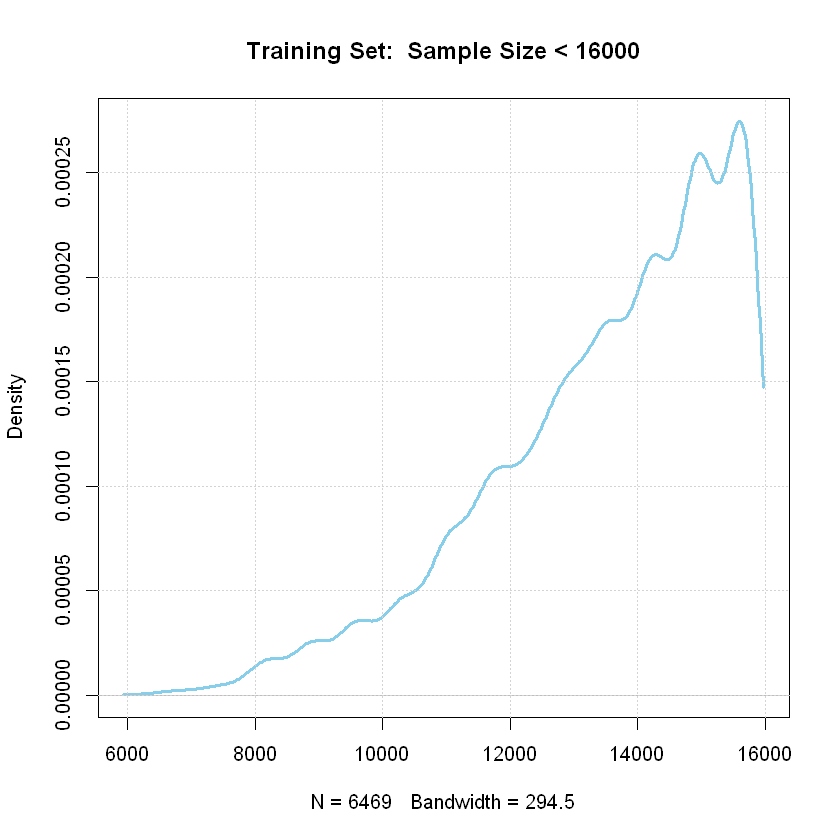

In [85]:
notOneSecond <- trainSoundInfo$samples[trainSoundInfo$samples != 16000]
plot(density(notOneSecond, from=min(notOneSecond), to=max(notOneSecond)),     
    col="skyblue", lwd=3,
    main="Training Set:  Sample Size < 16000")
grid()

As shown below, all of the test files have exactly 16000 samples.  None have fewer.

## Find size of each file

In [86]:
trainFileInfo <- file.info(trainFilenames, extra_cols=FALSE) %>%
                 rownames_to_column(var="filename")          %>%
                 select(filename, size)                      %>%
                 rename(sizeBytes=size)
head(trainFileInfo)

filename,sizeBytes
../../input/train/audio/bed/00176480_nohash_0.wav,32044
../../input/train/audio/bed/004ae714_nohash_0.wav,32044
../../input/train/audio/bed/004ae714_nohash_1.wav,29766
../../input/train/audio/bed/00f0204f_nohash_0.wav,32044
../../input/train/audio/bed/00f0204f_nohash_1.wav,32044
../../input/train/audio/bed/012c8314_nohash_0.wav,32044


## Combine data.frames

In [87]:
trainInfo <- inner_join(trainFileInfo, trainSoundInfo, by="filename")

In [88]:
head(trainInfo)

filename,sizeBytes,samples,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
../../input/train/audio/bed/00176480_nohash_0.wav,32044,16000,-16039,-1767.4,-18,0,11,337.0,24735,40774,-1.0628750,3043.4817,3336677cade31ae52d0f9e6288ad679d
../../input/train/audio/bed/004ae714_nohash_0.wav,32044,16000,-11421,-558.0,-149,-100,-50,285.1,12740,24161,-95.1914375,1220.9112,6ea166114fb6b1466c06e6cf0d88aa8d
../../input/train/audio/bed/004ae714_nohash_1.wav,29766,14861,-5797,-368.0,-143,-99,-53,136.0,7021,12818,-95.1184981,601.7973,1f68560e13cc793a24b7534c13c1f7e9
../../input/train/audio/bed/00f0204f_nohash_0.wav,32044,16000,-2474,-322.1,-43,-1,34,218.1,2327,4801,0.0856875,373.0592,fac98e7ea4e2f6f71814410d05d717cd
../../input/train/audio/bed/00f0204f_nohash_1.wav,32044,16000,-2527,-243.0,-38,0,33,166.1,2537,5064,0.0897500,396.6656,9460317598ff20131007088e4d2d1a8f
../../input/train/audio/bed/012c8314_nohash_0.wav,32044,16000,-3268,45.0,170,249,336,439.0,2887,6155,242.9836250,375.1439,8e9b5701dafd8d2d79f6b8062b7a11d0


Observation:  **sizeBytes = 2 bytes/sample * samples + 44 byte header**

Matches [Wave PCM soundfile format](http://soundfile.sapp.org/doc/WaveFormat/) specification.

In [89]:
stopifnot(trainInfo$sizeBytes == 2 * trainInfo$samples + 44)

Drop *sizeBytes* since that could be computed from *samples*.

Remove *dataDir* string from filenames.

In [90]:
trainInfo$filename <- substr(trainInfo$filename, nchar(dataDir)+1, nchar(trainInfo$filename))

## Split filenames into useful attributes

So what's a simple "tidy" version of the following?

Split filenames on any of three characters:  / _ .

In [91]:
splits <- strsplit(trainInfo$filename, "/|_|\\.")
length(splits)

[1] 64721

Show example of a split filename:

In [92]:
x = splits[[1]]
x

[1] "train"    "audio"    "bed"      "00176480" "nohash"   "0"        "wav"

Example of data.frame to be created below:

In [93]:
data.frame(dataset=x[1], word=x[3], speakerID=x[4], utteranceIndex=x[6], extension=x[7], stringsAsFactors=FALSE)

dataset,word,speakerID,utteranceIndex,extension
train,bed,00176480,0,wav


In [94]:
fileAttributes <- do.call(rbind, 
                          lapply(splits, function(x){
                                 data.frame(dataset=x[1], 
                                 word=x[3], 
                                 speakerID=x[4], 
                                 utteranceIndex=x[6], 
                                 extension=x[7], 
                                 stringsAsFactors=FALSE)
                 }))
head(fileAttributes)

dataset,word,speakerID,utteranceIndex,extension
train,bed,00176480,0,wav
train,bed,004ae714,0,wav
train,bed,004ae714,1,wav
train,bed,00f0204f,0,wav
train,bed,00f0204f,1,wav
train,bed,012c8314,0,wav


## Final trainInfo

Combine separate file attribute fields with *samples* and *md5sum*.

In [95]:
trainInfo <- cbind(trainInfo, fileAttributes) %>% 
    select(filename, dataset, word, speakerID, utteranceIndex, extension, samples, 
           min, Q10, Q25, median, Q75, Q90, max, range, mean, sd,
           md5sum)

In [96]:
dim(trainInfo)

[1] 64721    18

In [97]:
head(trainInfo)

filename,dataset,word,speakerID,utteranceIndex,extension,samples,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
train/audio/bed/00176480_nohash_0.wav,train,bed,00176480,0,wav,16000,-16039,-1767.4,-18,0,11,337.0,24735,40774,-1.0628750,3043.4817,3336677cade31ae52d0f9e6288ad679d
train/audio/bed/004ae714_nohash_0.wav,train,bed,004ae714,0,wav,16000,-11421,-558.0,-149,-100,-50,285.1,12740,24161,-95.1914375,1220.9112,6ea166114fb6b1466c06e6cf0d88aa8d
train/audio/bed/004ae714_nohash_1.wav,train,bed,004ae714,1,wav,14861,-5797,-368.0,-143,-99,-53,136.0,7021,12818,-95.1184981,601.7973,1f68560e13cc793a24b7534c13c1f7e9
train/audio/bed/00f0204f_nohash_0.wav,train,bed,00f0204f,0,wav,16000,-2474,-322.1,-43,-1,34,218.1,2327,4801,0.0856875,373.0592,fac98e7ea4e2f6f71814410d05d717cd
train/audio/bed/00f0204f_nohash_1.wav,train,bed,00f0204f,1,wav,16000,-2527,-243.0,-38,0,33,166.1,2537,5064,0.0897500,396.6656,9460317598ff20131007088e4d2d1a8f
train/audio/bed/012c8314_nohash_0.wav,train,bed,012c8314,0,wav,16000,-3268,45.0,170,249,336,439.0,2887,6155,242.9836250,375.1439,8e9b5701dafd8d2d79f6b8062b7a11d0


In [98]:
write.csv(trainInfo, "train-Kaggle-Speech-Recognition-File-Inventory.csv", row.names=FALSE)

## Number of unique train speakers

In [99]:
length(unique(trainInfo$speakerID))

[1] 1881

## Number of train utterances by word

(zero-based indexing here)

In [100]:
wordUtteranceCounts <- as.data.frame.matrix( table(trainInfo$word, as.numeric(trainInfo$utteranceIndex)) )
wordUtteranceCounts <- cbind(wordUtteranceCounts, Total=apply(wordUtteranceCounts, 1, sum))
wordUtteranceCounts

,0,1,2,3,4,5,6,7,8,9,10,11,Total
bed,1177,411,99,21,4,1,0,0,0,0,0,0,1713
bird,1194,410,109,17,1,0,0,0,0,0,0,0,1731
cat,1180,413,111,27,2,0,0,0,0,0,0,0,1733
dog,1209,417,101,15,4,0,0,0,0,0,0,0,1746
down,1206,567,257,168,149,5,3,3,1,0,0,0,2359
eight,1179,561,276,173,150,8,3,1,1,0,0,0,2352
five,1181,571,272,173,149,6,4,1,0,0,0,0,2357
four,1194,586,260,169,148,8,3,2,1,1,0,0,2372
go,1182,574,271,170,152,10,7,4,1,1,0,0,2372
happy,1178,415,124,22,2,1,0,0,0,0,0,0,1742


# Test Files

## Get names of all test files

In [101]:
testFilenames <- list.files(path=paste0(dataDir, "test"), 
                            pattern="^.*\\.wav$",
                            recursive=TRUE, full.names=TRUE)

length(testFilenames)
head(testFilenames)

[1] 158538

[1] "../../input/test/audio/clip_000044442.wav" "../../input/test/audio/clip_0000adecb.wav"
[3] "../../input/test/audio/clip_0000d4322.wav" "../../input/test/audio/clip_0000fb6fe.wav"
[5] "../../input/test/audio/clip_0001d1559.wav" "../../input/test/audio/clip_0002256ed.wav"

## Create md5sum and collect sound properties for each file

In [102]:
cluster <- makePSOCKcluster(detectCores() - 2)
registerDoParallel(cluster)   

testSoundInfo <- foreach(i = 1:length(testFilenames), .combine=rbind) %dopar%
{    
    soundWave <- tuneR::readWave(testFilenames[i])
    
    q <- quantile(soundWave@left, c(0.0, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0))  
    
    data.frame(
           filename          = testFilenames[i],          
           samples           = length(soundWave@left),
           durationSeconds   = length(soundWave@left) / soundWave@samp.rate,
           samplingRateHertz = soundWave@samp.rate,
           channels          = ifelse(soundWave@stereo, "Stero", "Mono"),
           pcmIntFormat      = soundWave@pcm,
           bitsPerSample     = soundWave@bit,
        
           # Waveform stats
           min               = q[1],   # Quantiles
           Q10               = q[2],
           Q25               = q[3],
           median            = q[4],
           Q75               = q[5],
           Q90               = q[6],
           max               = q[7],

           range             = q[7] - q[1],

           mean              = mean(soundWave@left),
           sd                = sd(soundWave@left),                                                     
        
           md5sum            = tools::md5sum(testFilenames[i]),
        
           row.names         = NULL,
           stringsAsFactors  = FALSE)
}

stopCluster(cluster)

## Verify sound properties common for all test files

In [103]:
dim(testSoundInfo)

[1] 158538     18

In [120]:
head(testSoundInfo)

filename,samples,durationSeconds,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
test/audio/clip_000044442.wav,16000,1,-19364,-1187.6,-113.00,6,128,2612.6,11836,31200,-11.9253750,3110.6630,2fdd0b20ce292dd241731997644480f3
test/audio/clip_0000adecb.wav,16000,1,-7783,-492.1,-29.00,0,26,390.0,11594,19377,-0.2610625,885.3153,d950098ef59227be68c5168fb116c401
test/audio/clip_0000d4322.wav,16000,1,-10175,-2030.2,-569.25,-3,118,1983.2,14092,24267,0.0138125,2052.8181,6df124df1eaa7f24cd76d30c80190c38
test/audio/clip_0000fb6fe.wav,16000,1,-2748,-96.0,-45.00,2,46,92.0,2775,5523,-0.6893750,193.1339,dc6083b93c227585a531d2414c42cd84
test/audio/clip_0001d1559.wav,16000,1,-20120,-4109.2,-256.00,-1,217,4175.0,21861,41981,-4.1986250,4206.9926,eb966b44bf6cde8b8f31156900cb22a7
test/audio/clip_0002256ed.wav,16000,1,-5786,-1182.1,-53.00,2,252,1163.1,4440,10226,2.3092500,1124.2620,3e1c2b8e9d8e9f24d26e6b1a82b8b634


In [121]:
table(testSoundInfo$samplingRateHertz)

< table of extent 0 >

In [122]:
table(testSoundInfo$channels)

< table of extent 0 >

In [107]:
table(testSoundInfo$pcmIntFormat)


  TRUE 
158538 

In [108]:
table(testSoundInfo$bitsPerSample)


    16 
158538 

Since the above sound properties are verified to be constants, let's not bother with them

In [109]:
testSoundInfo <- testSoundInfo %>% select(-samplingRateHertz, -channels, -pcmIntFormat, -bitsPerSample)

In [110]:
head(testSoundInfo)

filename,samples,durationSeconds,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
../../input/test/audio/clip_000044442.wav,16000,1,-19364,-1187.6,-113.00,6,128,2612.6,11836,31200,-11.9253750,3110.6630,2fdd0b20ce292dd241731997644480f3
../../input/test/audio/clip_0000adecb.wav,16000,1,-7783,-492.1,-29.00,0,26,390.0,11594,19377,-0.2610625,885.3153,d950098ef59227be68c5168fb116c401
../../input/test/audio/clip_0000d4322.wav,16000,1,-10175,-2030.2,-569.25,-3,118,1983.2,14092,24267,0.0138125,2052.8181,6df124df1eaa7f24cd76d30c80190c38
../../input/test/audio/clip_0000fb6fe.wav,16000,1,-2748,-96.0,-45.00,2,46,92.0,2775,5523,-0.6893750,193.1339,dc6083b93c227585a531d2414c42cd84
../../input/test/audio/clip_0001d1559.wav,16000,1,-20120,-4109.2,-256.00,-1,217,4175.0,21861,41981,-4.1986250,4206.9926,eb966b44bf6cde8b8f31156900cb22a7
../../input/test/audio/clip_0002256ed.wav,16000,1,-5786,-1182.1,-53.00,2,252,1163.1,4440,10226,2.3092500,1124.2620,3e1c2b8e9d8e9f24d26e6b1a82b8b634


## Look at sample size differences

All test files are exactly 16000 samples (1 sec), and 32044 bytes.

In [111]:
fivenum(testSoundInfo$samples)
table(testSoundInfo$samples)

[1] 16000 16000 16000 16000 16000


 16000 
158538 

Verify all test file sizes are the same

In [112]:
testFileInfo <- file.info(testFilenames, extra_cols=FALSE)     %>%
                          rownames_to_column(var="filename")   %>%
                          select(filename, size)               %>%
                          rename(sizeBytes=size)
head(testFileInfo)

filename,sizeBytes
../../input/test/audio/clip_000044442.wav,32044
../../input/test/audio/clip_0000adecb.wav,32044
../../input/test/audio/clip_0000d4322.wav,32044
../../input/test/audio/clip_0000fb6fe.wav,32044
../../input/test/audio/clip_0001d1559.wav,32044
../../input/test/audio/clip_0002256ed.wav,32044


In [113]:
stopifnot( all(testFileInfo$sizeBytes == 32044) ) 

Remove *dataDir* string from filenames.

In [114]:
testSoundInfo$filename <- substr(testSoundInfo$filename, nchar(dataDir)+1, nchar(testSoundInfo$filename))

## Split filenames into useful attributes

In [115]:
splits <- strsplit(testSoundInfo$filename, "/|_|\\.")
length(splits)

[1] 158538

In [116]:
splits[[1]]

[1] "test"      "audio"     "clip"      "000044442" "wav"

In [123]:
fileAttributes <- do.call(rbind, 
                          lapply(splits, function(x){
                                 data.frame(dataset=x[1], 
                                 speakerID=x[4], 
                                 extension=x[5], 
                                 stringsAsFactors=FALSE)
                 }))
head(fileAttributes)

dataset,speakerID,extension
test,000044442,wav
test,0000adecb,wav
test,0000d4322,wav
test,0000fb6fe,wav
test,0001d1559,wav
test,0002256ed,wav


## Final testInfo

In [124]:
testInfo <- cbind(testSoundInfo, fileAttributes) %>%
            select(filename, dataset, speakerID, extension, samples, 
                   min, Q10, Q25, median, Q75, Q90, max, range, mean, sd,
                   md5sum)

In [125]:
dim(testInfo)

[1] 158538     16

In [140]:
head(testInfo)

filename,dataset,speakerID,extension,samples,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum,word,utteranceIndex
test/audio/clip_000044442.wav,test,000044442,wav,16000,-19364,-1187.6,-113.00,6,128,2612.6,11836,31200,-11.9253750,3110.6630,2fdd0b20ce292dd241731997644480f3,,0
test/audio/clip_0000adecb.wav,test,0000adecb,wav,16000,-7783,-492.1,-29.00,0,26,390.0,11594,19377,-0.2610625,885.3153,d950098ef59227be68c5168fb116c401,,0
test/audio/clip_0000d4322.wav,test,0000d4322,wav,16000,-10175,-2030.2,-569.25,-3,118,1983.2,14092,24267,0.0138125,2052.8181,6df124df1eaa7f24cd76d30c80190c38,,0
test/audio/clip_0000fb6fe.wav,test,0000fb6fe,wav,16000,-2748,-96.0,-45.00,2,46,92.0,2775,5523,-0.6893750,193.1339,dc6083b93c227585a531d2414c42cd84,,0
test/audio/clip_0001d1559.wav,test,0001d1559,wav,16000,-20120,-4109.2,-256.00,-1,217,4175.0,21861,41981,-4.1986250,4206.9926,eb966b44bf6cde8b8f31156900cb22a7,,0
test/audio/clip_0002256ed.wav,test,0002256ed,wav,16000,-5786,-1182.1,-53.00,2,252,1163.1,4440,10226,2.3092500,1124.2620,3e1c2b8e9d8e9f24d26e6b1a82b8b634,,0


In [141]:
testInfo <- testInfo                       %>% 
            select(-word, -utteranceIndex) %>%
            arrange(filename)

In [142]:
write.csv(testInfo, "test-Kaggle-Speech-Recognition-File-Inventory.csv", row.names=FALSE)

## Number of unique test speakers

All test speakerIDs are unique

In [127]:
length(unique(testInfo$speakerID))

[1] 158538

# Duplicate Files

In [128]:
testInfo$word <- ""
testInfo$utteranceIndex <- 0
allInfo <- rbind(trainInfo, testInfo)

In [129]:
dim(allInfo)

[1] 223259     18

In [130]:
counts <- table(md5sum=allInfo$md5sum)          %>% 
          as.data.frame(stringsAsFactors=FALSE)

In [131]:
table(counts$Freq)


     1      2      3      4      5      6   3710 
215795   1557    172     27      2      1      1 

In [132]:
duplicates <- counts            %>% 
              filter(Freq > 1)  %>%
              arrange(desc(Freq))

Warning message:
"package 'bindrcpp' was built under R version 3.4.1"

In [133]:
head(duplicates)

md5sum,Freq
800ea34119b791a1be054aafd09fc896,3710
b57a0367e5aa3adf7761c4285e12637a,6
61c65e886789d76be18a9bcf79369f47,5
96c3f8655b50b3ee473f4efcf089efc4,5
0186604b63475ef175e2f4e582dda258,4
215ec163f0369ebc5204e5aa29693694,4


In [134]:
duplicateIds <- sort(unique(duplicates$md5sum))

In [135]:
select <- allInfo$md5sum %in% duplicateIds
duplicates <- allInfo[select,] %>% arrange(md5sum)
row.names(duplicates) <- NULL
dim(duplicates)

[1] 7464   18

In [136]:
head(duplicates)

filename,dataset,word,speakerID,utteranceIndex,extension,samples,min,Q10,Q25,median,Q75,Q90,max,range,mean,sd,md5sum
test/audio/clip_91cd9ccfc.wav,test,,91cd9ccfc,0,wav,16000,-2938,-195.0,-6.00,1,9,245.0,2318,5256,-0.343875,348.0375,001d47276ac8f75c8bb4dd0c3923c976
test/audio/clip_f29207b90.wav,test,,f29207b90,0,wav,16000,-2938,-195.0,-6.00,1,9,245.0,2318,5256,-0.343875,348.0375,001d47276ac8f75c8bb4dd0c3923c976
train/audio/no/cb8f8307_nohash_3.wav,train,no,cb8f8307,3,wav,16000,-15248,-1400.0,-14.00,0,16,1395.2,13291,28539,2.388750,1901.1607,00f40d14e950f82ce35618e9912e7c23
train/audio/no/cb8f8307_nohash_5.wav,train,no,cb8f8307,5,wav,16000,-15248,-1400.0,-14.00,0,16,1395.2,13291,28539,2.388750,1901.1607,00f40d14e950f82ce35618e9912e7c23
test/audio/clip_622472139.wav,test,,622472139,0,wav,16000,-9117,-1586.1,-60.25,-2,21,1457.1,11446,20563,-3.391188,1837.1585,0100a5817d788c73e3abea746ef82f7a
test/audio/clip_c89b44152.wav,test,,c89b44152,0,wav,16000,-9117,-1586.1,-60.25,-2,21,1457.1,11446,20563,-3.391188,1837.1585,0100a5817d788c73e3abea746ef82f7a


In [137]:
duplicatesSummary <- table(duplicates$md5sum, duplicates$dataset)
duplicatesSummary

                                  
                                   test train
  001d47276ac8f75c8bb4dd0c3923c976    2     0
  00f40d14e950f82ce35618e9912e7c23    0     2
  0100a5817d788c73e3abea746ef82f7a    2     0
  0103b53d1187d4ed368dcde3de51480a    2     0
  010f29432bb090847709a13019612d68    0     2
  011562a2b2413670b9a3f925064d8b68    2     0
  01209921541626c71412aaebb7a36808    0     2
  01477edd8dd2f3a003b4cb8c5a8b2f7d    2     0
  0186604b63475ef175e2f4e582dda258    4     0
  018db8f781099ae79e7d3fe04f478fb0    2     0
  01d81b632f2da9b6cf776c126f657170    0     2
  01e5e64829eac9a95277fba8db77e6b8    2     0
  023af5bde5e94287795b5e6cd9035454    2     0
  027e1117f37ec381941680bc83ede2b2    2     0
  0327503658bcc9fac6f0162693f8e83c    2     0
  03397df7b85dbbbfa92551a5f733256f    0     2
  0359d7d245cbd618adc449974da29e03    0     2
  03c1a951b3dcd1c84aa5ab04ebb12696    2     0
  03c4bc26787f6e32b21cedd547d943cd    2     0
  046e00ec6f7b0cf1b7af08716c4aba0a    3     0

In [138]:
write.csv(duplicates,        "duplicates-Kaggle-Speech-Recognition-Inventory.csv", row.names=FALSE)
write.csv(duplicatesSummary, "duplicates-Summary.csv")